In [1]:
from my_demo_fn import main
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple
import os
import csv

%load_ext autoreload
%autoreload 2

/home/nripstein/miniconda3/envs/shan_et_al2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def condense_dataframe(df: pd.DataFrame, priority: dict = None):
    """
    deals with duplicate images which have multiple contact states
    
    Condenses a pandas DataFrame by ensuring each 'image' entry is unique and retains
    the most relevant 'contact_label_pred' based on a set priority.

    The function operates under the rule that if multiple entries exist for the same 'image',
    it prioritizes keeping the entry with 'contact_label_pred' as "Portable Object Contact" over
    "Stationary Object Contact", and "Stationary Object Contact" over "No Contact". This is
    done by sorting the DataFrame according to the 'image' and a custom priority assigned to
    'contact_label_pred', then removing duplicate 'image' entries while keeping the entry with the
    highest-priority 'contact_label_pred'.
    """
    if priority is None:
        priority = {
            "Portable Object": 1,
            "Portable Object Contact": 1,
            "Stationary Object Contact": 2,
            "No Contact": 3
        }

    # Sort the DataFrame based on 'image' and the custom priority of 'contact_label_pred'

    df['priority'] = df['contact_label_pred'].map(priority)

    df = df.sort_values(by=['frame_id', 'priority'])

    # Drop the 'priority' column as it's no longer needed after sorting
    df.drop('priority', axis=1, inplace=True)

    # Remove duplicates, keeping the first occurrence
    df = df.drop_duplicates(subset='frame_id', keep='first')

    return df.iloc[df['frame_id'].map(lambda x: int(x.split('_')[0])).argsort()].reset_index(drop=True)

def get_last_indices_of_consecutive_labels2(df, transformation_dict):
    last_indices = {}
    last_label = None

    for index, row in df.iterrows():
        current_label = row['contact_label_pred']
        # If the current label is different from the last one, update the dictionary
        if current_label != last_label:
            if last_label is not None:  # to skip the very first label
                # Transform the label using the transformation_dict
                transformed_label = transformation_dict.get(last_label, last_label)
                last_indices[last_index] = transformed_label
            last_label = current_label
        last_index = index  # keep track of the last index
    
    # Add the last label and index after the loop
    # Transform the label using the transformation_dict
    transformed_label = transformation_dict.get(current_label, current_label)
    last_indices[last_index] = transformed_label
    return last_indices

def csv_to_tuples(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row if it exists
        for row in reader:
            # Skip the first column and convert the rest to integers
            holding_transitions, not_holding_transitions = map(int, row[1:])
            data.append((holding_transitions, not_holding_transitions))
    return data

def comparison_dicts(gt_transitions: List[tuple], max_len) -> Tuple[dict]:
    """
    Args:
        gt_transitions: List of tuples of ground truth transition frames in form [(start1, end1), (start2, end2) ...]
    """

    def transition_to_dict(trns: List[Tuple[int, int]]) -> dict:
        output_dict = {}
        for bound in trns:
            output_dict[bound[0]] = "red"
            output_dict[bound[1]] = "green"
        return output_dict
    
    trans_dict_gt = transition_to_dict(gt_transitions)
    trans_dict_gt[max_len] = "red"  # need to make remaining frames without contact red
    return trans_dict_gt


def plot_colored_horizontal_lines(col_dict1, col_dict2, line_height=1, label_offset=0.5, x_ticks_interval=None):
    """
    Plot two colored horizontal lines with labels to the left of them.

    :param col_dict1: Dictionary for the first line with keys as the end index of the color and values as the colors
    :param col_dict2: Dictionary for the second line with keys as the end index of the color and values as the colors
    :param line_height: Height of the lines
    :param label_offset: Offset to control the distance between lines and labels
    :param x_ticks_interval: Interval for x-axis ticks (set to None for automatic ticks)

    Example:
        col_dict1 = {15: 'blue', 20: 'red', 200: 'pink'}
        col_dict2 = {10: 'green', 30: 'purple', 90: 'orange', 120: "green"}
        plot_colored_horizontal_lines(col_dict1, col_dict2, line_height=1, label_offset=0.5, x_ticks_interval=50)
    """
    line_width = 10

    # Calculate figure height based on line_height and x_ticks_interval
    figure_height = line_height * 1.25 if x_ticks_interval else line_height

    # Create a figure and a set of subplots
    fig, ax = plt.subplots(figsize=(line_width, figure_height))

    # Initial start position for the first line
    start1 = 0
    for end, color in sorted(col_dict1.items()):
        ax.plot([start1, end], [0, 0], color=color, lw=line_width, solid_capstyle='butt')
        start1 = end

    # Initial start position for the second line
    start2 = 0
    for end, color in sorted(col_dict2.items()):
        ax.plot([start2, end], [-line_height, -line_height], color=color, lw=line_width, solid_capstyle='butt')
        start2 = end

    # Set the limits for the x-axis and y-axis
    max_x = max(max(col_dict1.keys()), max(col_dict2.keys()))
    ax.set_xlim(0, max_x)
    ax.set_ylim(-2 * line_height, line_height)

    # Remove the y-axis
    ax.yaxis.set_visible(False)

    # Remove the spines of the plot
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add labels to the left of the lines with appropriate offset
    ax.text(-label_offset, 0, "Pred:", va='center', ha='right', fontsize=12, color='black')
    ax.text(-label_offset, -line_height, "GT:", va='center', ha='right', fontsize=12, color='black')

    # Set x-axis ticks every x_ticks_interval units if specified
    if x_ticks_interval is not None:
        ax.set_xticks(range(0, int(max_x) + 1, x_ticks_interval))
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis ticks by 45 degrees

    # Show the plot
    plt.tight_layout()
    plt.show()

transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "yellow", "Self Contact": "red"}

In [2]:
GOPR4366_dir = '/home/nripstein/Documents/thesis data/lab participants/p6/'

GOPR4366_results = main(save_imgs=False, img_dir=GOPR4366_dir + 'GOPR4366c.mp4', blue_refine=True)
GOPR4366_results.to_csv(GOPR4366_dir + "GOPR4366c_full_pred.csv")

Processing Images: 100%|██████████| 1740/1740 [01:11<00:00, 24.49it/s]


In [3]:
nr_dir = '/home/nripstein/Documents/thesis data/thesis labels/nr labels/all_nr/'

nr_results = main(save_imgs=False, img_dir=nr_dir + 'nr_shrunk/', blue_refine=True)
nr_results.to_csv(nr_dir + "pred_every_obj.csv", index=False)

Processing Images: 100%|██████████| 14337/14337 [09:57<00:00, 24.00it/s]


### SR

/home/nripstein/Documents/thesis data/thesis labels/sr labels/sr1/sr1_shrunk


Processing Images: 100%|██████████| 15432/15432 [10:36<00:00, 24.25it/s]


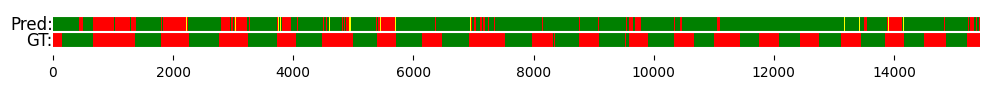

In [5]:
transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "yellow", "Self Contact": "red"}

def pred_imgs(dir_: str, shrunk_add: str):
    if dir_[-1] != "/":
        raise ValueError("NOAH! DIR NEEDS TO END IN '/'")

    print(dir_ + shrunk_add)
    raw_preds = main(save_imgs=False, img_dir=dir_ + shrunk_add, blue_refine=True)
    raw_preds.to_csv(dir_ + "pred_every_obj.csv", index=False)
    preds_cond = condense_dataframe(raw_preds)
    pred_dict = get_last_indices_of_consecutive_labels2(preds_cond, transformation_dict)


    gt = csv_to_tuples(dir_ + "changepoints.csv")
    gt_dict = comparison_dicts(gt, len(preds_cond))

    plot_colored_horizontal_lines(pred_dict, gt_dict)

sr_base = '/home/nripstein/Documents/thesis data/thesis labels/sr labels/'

# directories = [
#     sr_base + 'sr1/',
#     sr_base + 'sr2/',
#     sr_base + 'sr3/',
#     sr_base + 'sr4/',
# ]

# shrunks = [f"sr{i}_shrunk" for i in (1, 2, 3, 4)]

directories = [
    sr_base + 'sr1/',
    # sr_base + 'sr2/',
    # sr_base + 'sr3/',
    # sr_base + 'sr4/',
]

shrunks = [f"sr{i}_shrunk" for i in (1, )]

for dir, shrunk in zip(directories, shrunks):
    pred_imgs(dir, shrunk)

### SV

/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv1_frames/


Processing Images: 100%|██████████| 15244/15244 [10:33<00:00, 24.07it/s]


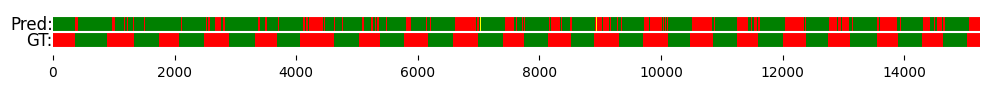

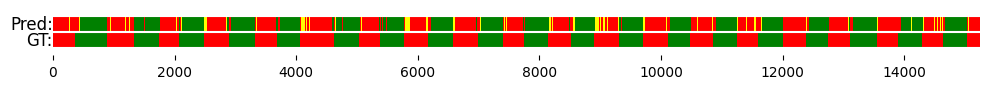

/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv2_frames/


Processing Images: 100%|██████████| 3851/3851 [02:41<00:00, 23.87it/s]


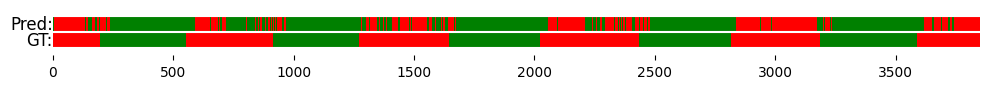

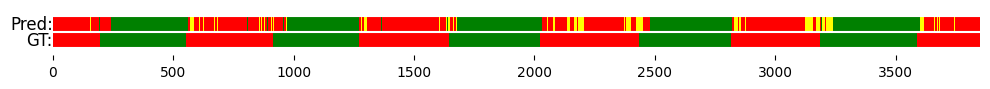

/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv3_frames/


Processing Images: 100%|██████████| 5348/5348 [03:38<00:00, 24.43it/s]


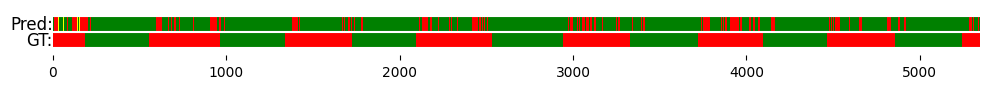

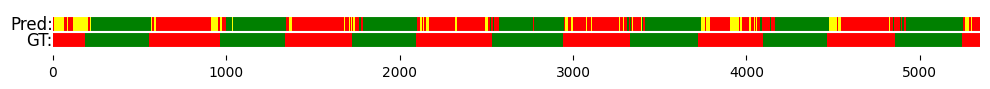

/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv4_frames/


Processing Images: 100%|██████████| 6974/6974 [04:29<00:00, 25.84it/s]


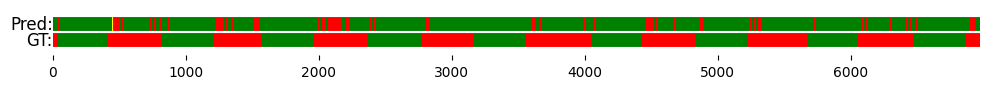

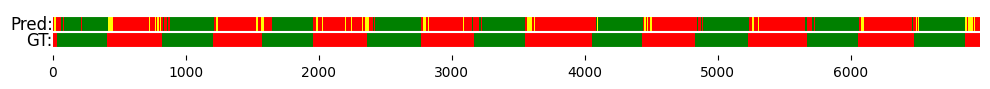

/home/nripstein/Documents/thesis data/thesis labels/sv labels/sv5_frames/


Processing Images: 100%|██████████| 3845/3845 [02:28<00:00, 25.89it/s]


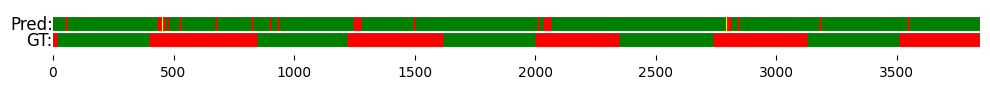

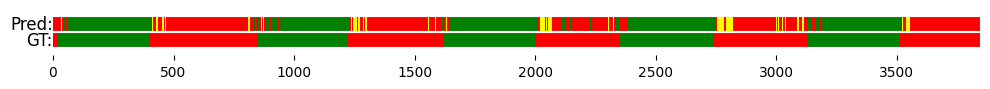

In [11]:
transformation_dict = {"Portable Object Contact": "green", "Portable Object": "green", "Stationary Object Contact": "red", "No Contact": "yellow", "Self Contact": "red"}

def pred_imgs(dir_: str, shrunk_add: str):
    if dir_[-1] != "/":
        raise ValueError("NOAH! DIR NEEDS TO END IN '/'")
    print(dir_)
    raw_preds = main(save_imgs=True, img_dir=dir_ + shrunk_add, blue_refine=True)
    raw_preds.to_csv(dir_ + "pred_every_obj.csv", index=False)
    preds_cond = condense_dataframe(raw_preds)
    pred_dict = get_last_indices_of_consecutive_labels2(preds_cond, transformation_dict)


    gt = csv_to_tuples(dir_ + "changepoints.csv")
    gt_dict = comparison_dicts(gt, len(preds_cond))

    plot_colored_horizontal_lines(pred_dict, gt_dict)
    plot_colored_horizontal_lines(get_last_indices_of_consecutive_labels2(condense_dataframe(raw_preds, priority_old),transformation_dict), 
                                    gt_dict)

sv_base = '/home/nripstein/Documents/thesis data/thesis labels/sv labels/'

directories = [sv_base + f'sv{i}_frames/' for i in (1, 2, 3, 4, 5)]

shrunks = [f"sv{i}_shrunk" for i in (1, 2, 3, 4, 5)]

priority_old = {
            "Portable Object": 3,
            "Portable Object Contact": 3,
            "Stationary Object Contact": 2,
            "No Contact": 1
        }

for dir, shrunk in zip(directories, shrunks):
    pred_imgs(dir, shrunk)